In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv('gdrive/MyDrive/Consumer_Complaints.csv')
df = df[['Consumer Complaint','Product']]


In [ ]:

df.rename(columns = {'Consumer Complaint':'Complaints'}, inplace = True)
df.head(10)

,Complaints,Product
0,NaN,Mortgage
1,I have outdated information on my credit repor...,Credit reporting
2,I purchased a new car on XXXX XXXX. The car de...,Consumer Loan
3,NaN,Credit card
4,NaN,Debt collection
5,NaN,Mortgage
6,NaN,Debt collection
7,An account on my credit report has a mistaken ...,Credit reporting
8,NaN,Mortgage
9,NaN,Mortgage


In [ ]:
df=df.head(50000)

In [ ]:
df.shape

(1025010, 2)

In [ ]:
df.index = range(1025010)

In [ ]:
df = df[df['Complaints'].notnull()]


In [ ]:
df['Complaints'].apply(lambda x: len(x.split(' '))).sum()

54922096

In [ ]:
#We have over 54 million words, it is not a small data set.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


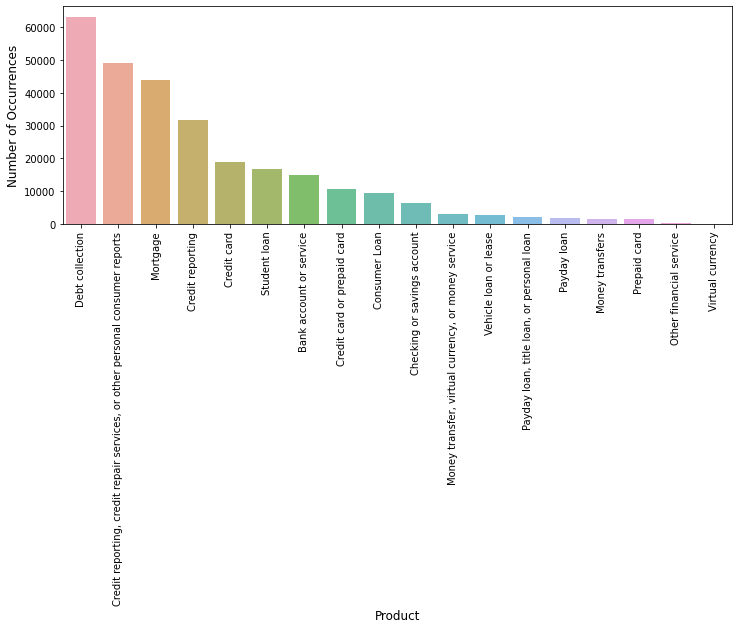

In [ ]:
cnt_pro = df['Product'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [ ]:
#The classes are imbalanced. However, a naive classifier that predicts everything to be Debt collection will only achieve over 20% accuracy.

#Let's have a look a few examples of complaint narrative and its associated pr

In [ ]:
def print_complaint(index):
    example = df[df.index == index][['Complaints', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [ ]:
print_complaint(12)

This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine.
Product: Debt collection


# **DATA PREPROCESSING** 

In [ ]:
#Text preprocessing
#Below we define a function to convert text to lower-case and strip punctuation/symbols from words and so on.

from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Complaints'] = df['Complaints'].apply(cleanText)

In [ ]:
#Train/test split 70/30
train, test = train_test_split(df, test_size=0.3, random_state=42)


In [ ]:
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Complaints']), tags=[r.Product]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Complaints']), tags=[r.Product]), axis=1)

In [ ]:
#what the taining looks like
train_tagged.values[30]

TaggedDocument(words=['went', 'to', 'mi', 'and', 'was', 'told', 'would', 'have', 'loan', 'thru', 'genesis', 'lending', 'which', 'learned', 'was', 'been', 'since', 'investigated', 'have', 'had', 'issues', 'with', 'the', 'instiutute', 'itself', 'and', 'can', 'not', 'rid', 'myself', 'on', 'the', 'ongoing', 'debt', 'and', 'no', 'way', 'to', 'fi', 'the', 'issue', 'am', 'in', 'debt', '16000.00', 'for', 'certificate', 'in', 'which', 'never', 'got', 'due', 'to', 'issues', 'with', 'promises', 'of', 'an', 'eternship', 'once', 'eternship', 'started', 'was', 'told', 'didnt', 'do', 'well', 'enough', 'or', 'only', 'given', 'limited', 'access', 'to', 'the', 'job', 'was', 'to', 'learn', 'the', 'genesis', 'loan', 'have', 'tried', 'to', 'resolve', 'but', 'get', 'phone', 'calls', 'and', 'letters', 'weekly', 'can', 'not', 'pay', 'back', 'any', 'money', 'if', 'am', 'unemployed', 'have', 'discussed', 'with', 'them', 'several', 'times', 'and', 'get', 'the', 'same', 'answer', 'its', 'unclear', 'to', 'me', 'al

**Training the model**
We'll instantiate a Doc2Vec model-Distributed Bag of Words (DBOW). In the Word2Vec architecture, the two algorithm names are “continuous bag of words” (cbow) and “skip-gram” (sg); in the Doc2Vec architecture, the corresponding algorithms are “distributed bag of words” (dbow) and “distributed memory” (dm).

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count()

In [ ]:
#Build a vocabulary

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 194469/194469 [00:00<00:00, 556174.46it/s]


In [ ]:
%%time
for epoch in range(20):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 194469/194469 [00:00<00:00, 2318229.53it/s]


CPU times: user 36min 29s, sys: 31.8 s, total: 37min 1s
Wall time: 20min 18s


## **Buliding the final vector feature for the classifier**

In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [ ]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.25960765492831006
Testing F1 score: 0.18703256454620423


**Distributed Memory with Averaging**
Distributed Memory (DM) acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document. We again instantiate a Doc2Vec model with a vector size with 300 words and iterating over the training corpus 30 times.

In [ ]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])


100%|██████████| 194469/194469 [00:00<00:00, 1975906.49it/s]


In [ ]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 194469/194469 [00:00<00:00, 2496608.91it/s]


CPU times: user 1h 23min 18s, sys: 2min 59s, total: 1h 26min 18s
Wall time: 48min 37s


## **Train Logistic Regression**


In [ ]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Testing accuracy 0.5932689423480713
Testing F1 score: 0.5831914055484937


In [ ]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [ ]:
pip install testfixtures


In [ ]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [ ]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

In [ ]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))